<a href="https://colab.research.google.com/github/Stavroskiig/MLP-kNN-NC-CIFAR-100/blob/main/NN_1st_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

1η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα νευρωνικό δίκτυο πολυστρωματικού perceptron (το δίκτυο μπορεί να είναι πλήρως συνδεδεμένο ή συνελικτικό ή συνδυασμός) που θα εκπαιδεύεται με τον αλγόριθμο back-propagation. Το NN αυτό θα
εκπαιδευτεί για να επιλύει οποιοδήποτε πρόβλημα κατηγοριοποίησης πολλών κλάσεων εκτός MNIST.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε Python χρησιμοποιώντας την βιβλιοθήκη `PyTorch` για την ανάπτυξη των νευρωνικών μοντέλων, η οποία είναι αρκετά δημοφιλής στην ερευνητική και εκπαιδευτική κοινότητα. Αντίστοιχα, για τα πρώτα μοντέλα της ενδιάμεσης εργασίας επιλέγω την `sklearn`.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-100 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Φόρτωση του dataset

1.   **Πρώτος τρόπος**

Αρχικά θα φορτώσω το σύνολο δεδομένων στο colab. Κατεβάζοντας τον αντίστοιχο φάκελο για την Python από το παραπάνω link, βρίσκω μέσα το αρχείο train, όπως και το test. Κάθε ένα από αυτά τα αρχεία είναι ένα Python "pickled" αντικείμενο που σχηματίστηκε με το cPickle. Με την παρακάτω συνάρτηση μπορώ να ανοίξω ένα τέτοιο αρχείο και να επιστρέψω ένα dictionary:

In [ ]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

Αποθήκευσα το σύνολο δεδομένων στο Google Drive, οπότε με τον παρακάτω τρόπο μπορώ να το φορτώσω και εδώ, δίνοντας άδεια στο Colab να επικοινωνεί με το Drive του λογαρισμού. Αυτό χρειάζεται να γίνει μόνο μία φορά.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Κάνω χρήση της προηγούμενης συνάρτησης για να πάρω το λεξικό.

In [ ]:
cifar100 = unpickle('/content/drive/MyDrive/cifar-100-python/train')

2.   **Δεύτερος τρόπος**

Εισάγω το dataset απευθείας από το PyTorch. Στη συνέχεια το χωρίζω σε train και test σετ ορίζοντας πρώτα τον transformer που μετατρέπει τις εικόνες σε tensors. Τέλος, ορίζω και τους data loaders, οι οποίοι φροντίζουν για τη φόρτωση, το shuffle και την ομαδοποίηση των δεδομένων, διευκολύνοντας την εκπαίδευση των μοντέλων.

In [ ]:
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR100(root='./data', train=False, transform=transform, download=True)

batch_size = 64
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

3.   **Τρίτος τρόπος**

Αυτός ο τρόπος είναι επίσης απλός, αλλά αφορά την χρήση του keras και το δείχνω χάριν πληρότητας. Ουσιαστικά παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 2s 0us/step


Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-99) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_tes**t: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-99) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

# Το CIFAR-100 Dataset

Κάπου έδω θα μελετήσω λίγο το dataset, την δομή του και το περιεχόμενό του. Για αυτό το σκοπό θα χρησιμοποιήσω την πρώτη μέθοδο φόρτωσής του. Γενικά, έχει 100 κλάσεις που περιέχει 600 εικόνες η καθεμιά. Υπάρχουν 500 εικόνες εκπαίδευσης και 100 εικόνες testing ανά κλάση. Οι 100 classes στο CIFAR-100 είναι χωρισμένες σε 20 υπερκλάσεις (superclasses). Κάθε εικόνα έχει μια "fine" ετικέτα (η κλάση στην οποία ανήκει) και μια "coarse" ετικέτα (η superclass στην οποία ανήκει).

In [ ]:
print(type(cifar100))
print(len(cifar100))

<class 'dict'>
5


Βλέπω πως το σύνολο cifar100 είναι ένα λεξικό με 5 κλειδιά. Τώρα θα τυπώσω τα κλειδιά αυτά.

In [ ]:
print("Keys:", list(cifar100.keys()))

Keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']


Θα τυπώσω και τις τιμές.

In [ ]:
%%capture
# κρύβω για τώρα το output
for key, value in cifar100.items():
    print(key, ":", value)

Ας δούμε τώρα από τι αποτελείται το λεξικό.
* **b'filenames'**: Περιέχει τα ονόματα των εικόνων.
* **b'batch_label'**: Περιέχει την ονομασία του τωρινού batch εκπαίδευσης.
* **b'fine_labels'**: Περιέχει την κλάση που ανήκει κάθε εικόνα.
* **b'coarse_labels'**: Περιέχει την superclass που ανήκει κάθε εικόνα.
* **b'data'**: Περιέχει τις εικόνες υπό την μορφή συνόλου pixels.

Το 'b' σημαίνει ότι οι συμβολοσειρές είναι σε μορφή byte και όχι σε μορφή χαρακτήρων Unicode.

In [ ]:
cifar100[b'data']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [ ]:
cifar100[b'data'].shape

(50000, 3072)

Επιβεβαιώνω πως έχω 50.000 εικόνες εκπαίδευσης και 3072 τιμές pixel που προκύπτουν από τα τρία κανάλια RGB με 3072/3=1024 το κάθενα. Κάθε κανάλι είναι ένας πίνακας με 32x32=1024 τιμές. Οι πρώτες 1024 καταχωρήσεις περιέχουν τις τιμές του κόκκινου (R) καναλιού, οι επόμενες 1024 το πράσινο (G) και οι τελευταίες 1024 το μπλε (B). Η εικόνα αποθηκεύεται με τέτοια σειρά, έτσι ώστε οι πρώτες 32 καταχωρήσεις του πίνακα να είναι οι τιμές του κόκκινου καναλιού της πρώτης σειράς της εικόνας.

In [ ]:
cifar100[b'data'][0]

array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)

In [ ]:
cifar100[b'data'][0].shape

(3072,)

Αυτές οι τίμες pixels είναι ουσιαστικά η πρώτη εικόνα του dataset. Ας την προβάλω κιόλας. Για αυτό με την εντολή `image = image.reshape(3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel. Στην συνέχεια προβάλω την εικόνα, αφού αλλάξω την σειρά όπως θέλει η `matplotlib`.

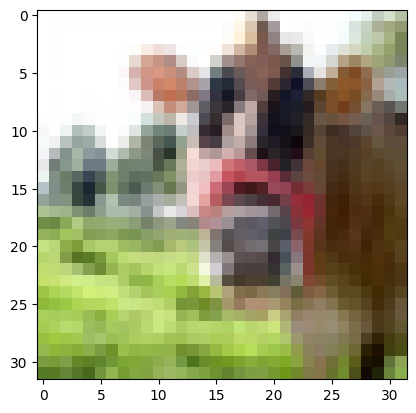

In [ ]:
image = cifar100[b'data'][0]
image = image.reshape(3,32,32).transpose(1,2,0)

from matplotlib import pyplot as plt
plt.imshow(image)

Τώρα θα εφαρμόσω τον ίδιο μετασχηματισμό για όλο το σύνολο. Με την εντολη `data = data.reshape(len(data), 3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel, ακριβώς όπως πριν. Πλέον ο πίνακας `data` είναι της μορφής `[num_images, num_channels, height, width] `. Εγώ όμως θέλω την μορφή `[num_images, height, width, num_channels]` ώστε να το δεχτεί σωστά η `matplotlib`. Οπότε με την εντολή `.transpose(0,2,3,1)` αλλάζω αυτή την σειρά.


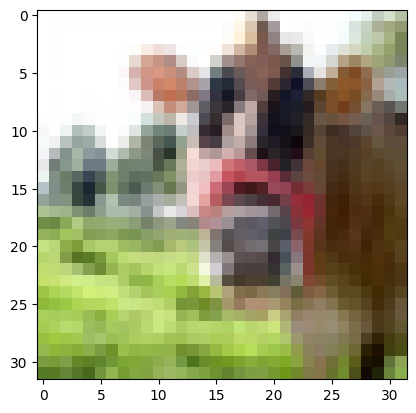

In [ ]:
data = cifar100[b'data']
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
plt.imshow(data[0])

Έλεγξα ότι η αναδιαμόρφωση έγινε σωστά. Τώρα θα προβάλω κάποια πλέγματα εικόνων.

<function matplotlib.pyplot.show(close=None, block=None)>

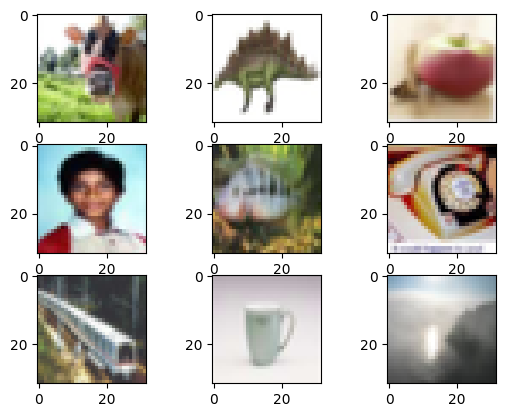

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data[i])
plt.show

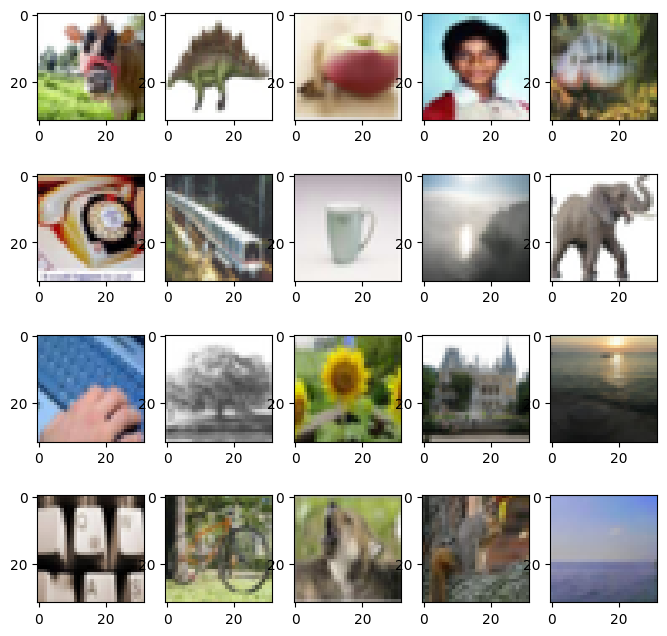

In [ ]:
columns = 5
rows = 4
fig = plt.figure(figsize=(8,8))
for i in range(1, columns*rows+1):
  fig.add_subplot(rows,columns,i)
  plt.imshow(data[i-1])
plt.show()

# Προεπεξεργασία του CIFAR-100

Αρχικά, θα το φορτώσω με την τρίτη μέθοδο αυτή την φορά, ώστε στη συνέχεια να προχωρήσω με τα υπό εξέταση μοντέλα, δηλαδή τα k-NN και Nearest Centroid. Αυτό το κάνω για απλούστευση της διαδικασίας.

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 11s 0us/step


Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [2]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Μετατρέπω τα σύνολα σε `float32`.

In [3]:
import numpy as np

x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [4]:
number_features = 3072

x_train = x_train.reshape([-1, number_features])
x_test = x_test.reshape([-1, number_features])

print("x_train:", x_train.shape, "x_test:", x_test.shape)

x_train: (50000, 3072) x_test: (10000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [5]:
x_train = x_train/255.0
x_test = x_test/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [6]:
number_classes = 100
number_superclasses = 20

Θα εφαρμόσω one-hot encoding, η οποία είναι μια μέθοδος που δέχεται ως είσοδο έναν πίνακα ακεραίων ή strings και συγκεκριμένα τα labels. Τα κωδικοποιεί χρησιμοποιώντας ένα σχήμα κωδικοποίησης one-hot (γνωστό και ως «one-of-K» ή «dummy»). Αυτό δημιουργεί μια binary στήλη για κάθε κατηγορία και επιστρέφει έναν αραιό πίνακα ή έναν πυκνό πίνακα (ανάλογα με την παράμετρο sparse_output). Αναμένω η έξοδος να είναι της μορφής που παρουσιάζεται στην εικόνα. Η συγκεκριμένη τεχνική πάντως δεν επηρεάζει την απόδοση αυτών των classifiers, παρά μόνο των νευρωνικών δικτύων που θα υλοποιηθούν αργότερα.
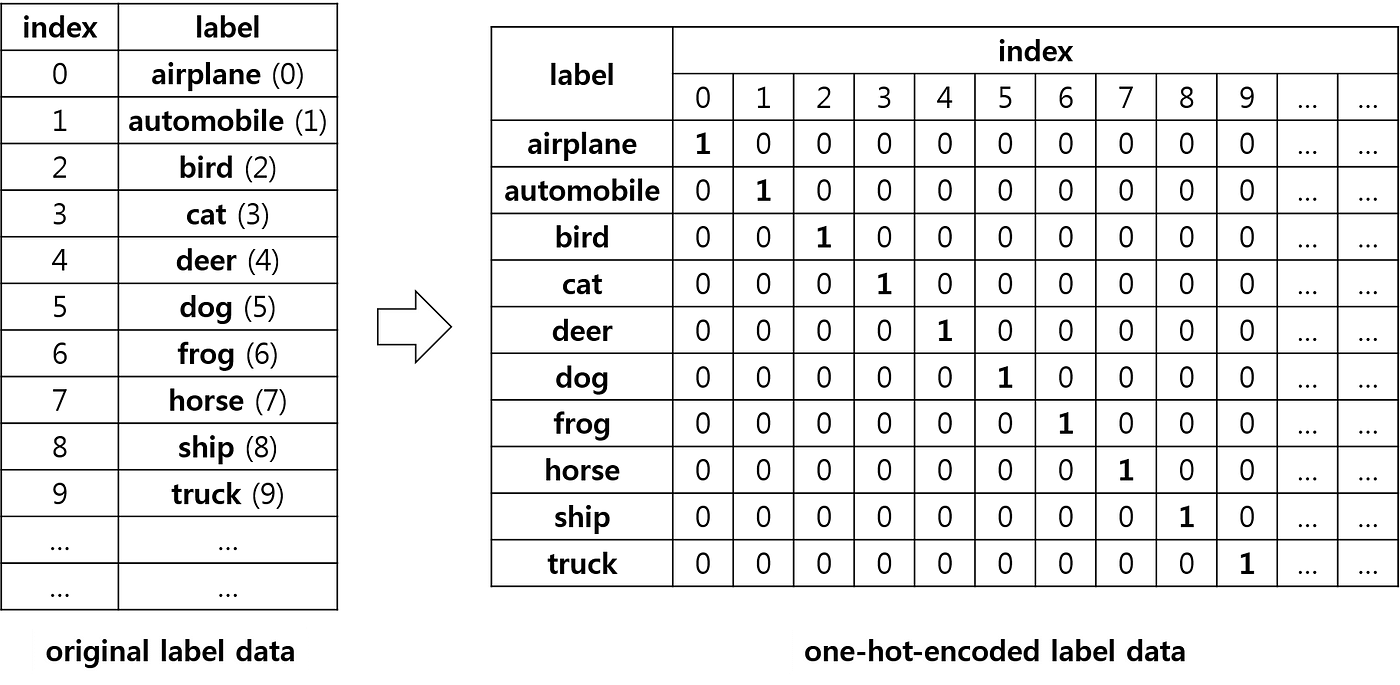

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

# k-NN Models

Εισάγω από την κατάλληλη βιβλιοθήκη (`sklearn`) τον κατηγοριοποιητή πλησιέστερου γείτονα.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

Εισάγω και την βιβλιοθήκη `time` για την χρονομέτρηση της εκπαίδευσης και της αξιολόγησης.

In [ ]:
import time

Ορίζω τις συναρτήσεις train και test αντίστοιχα.

In [18]:
def train_knn_classifier(x_train, y_train, n_neighbors, metric):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    start_time = time.time()
    knn_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return knn_classifier

In [19]:
def test_knn_classifier(knn_classifier, x_test, y_test):
    start_time = time.time()
    score = knn_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **1-NN Model**

Αρχικά φτιάχνω τον κατηγοριοποιητή ενός κοντινού γείτονα με `p=2`, δηλαδή επιλέγοντας την ευκλείδια απόσταση ως υπερπαράμετρο της μετρικής Minkowski.

Η απόσταση Minkowski είναι μια γενικευμένη απόσταση σε έναν κανονικοποιημένο διανυσματικό χώρο. Ακολουθεί ο τύπος που την ορίζει. Για c ίσο με 1, ο τύπος δίνει την απόσταση Manhattan. Όταν το c είναι ίσο με 2, δίνει την Euclidean απόσταση.

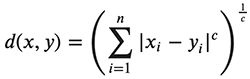

Η ευκλείδια απόσταση σύμφωνα με το σχήμα υπολογίζεται ως εξής. Αφαιρώ το X1 από το X2, τετραγωνίζω το αποτελέσμα, κάνω το ίδιο για τα Y1 και Y2, προσθέτω τα δύο τετράγωνα και στο τέλος τα "βάζω" κάτω από τετραγωνική ρίζα.

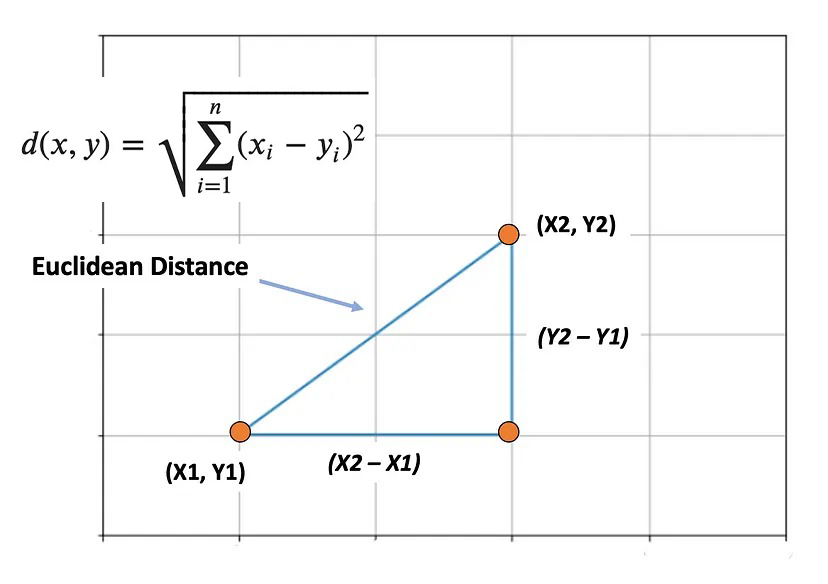

Συνεχίζω τώρα με το κατηγοριοποιητή.

In [21]:
knn_classifier_1 = train_knn_classifier(x_train, y_train, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1, x_test, y_test)

print(f"For the 1-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.1166s

Testing time: 133.0961s

For the 1-NN classifier with Euclidean distance metric, the accuracy is: 0.1755


Οπότε πετυχαίνω **0.1755** ακρίβεια, δηλαδή αρκετά χαμηλή. Τώρα θα δοκιμάσω αν αλλάζει κάτι ελέγχοντας τρεις γείτονες.

* **3-NN Model**

In [22]:
knn_classifier_3 = train_knn_classifier(x_train, y_train, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3, x_test, y_test)

print(f"For the 3-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.3490s

Testing time: 133.0266s

For the 3-NN classifier with Euclidean distance metric, the accuracy is: 0.1479


Παρατηρώ πως ναι μεν χρειάζεται παραπάνω χρόνο όπως αναμενόταν, αλλά η ακρίβεια έπεσε στο **0.1479**.

# Nearest Centroid Models

Όμοια με πριν, θα ορίσω πρώτα τις συναρτήσεις εκπαίδευσης και δοκιμής για καλύτερη ευελιξία.

In [24]:
from sklearn.neighbors import NearestCentroid
import time

In [25]:
def train_nearest_centroid_classifier(x_train, y_train, metric):
    ncc_classifier = NearestCentroid(metric=metric)

    start_time = time.time()
    ncc_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return ncc_classifier

In [26]:
def test_nearest_centroid_classifier(ncc_classifier, x_test, y_test):
    start_time = time.time()
    score = ncc_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **Ευκλείδια απόσταση**

Τώρα θα τεστάρω τον κατηγοριοποιητή `NearestCentroid`, αρχικά με μετρική την Ευκλείδια απόσταση.

In [27]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train, y_train, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test, y_test)

print(f"For the Nearest Centroid classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.2313s

Testing time: 0.3851s

For the Nearest Centroid classifier with Euclidean distance metric, the accuracy is: 0.1004


Παρατηρώ πως είναι πολύ γρήγορο, αλλά με χειρότερη ακρίβεια (**0.1004**) σε σχέση με τα k-NN. Θα δοκιμάσω να αλλάξω την μετρική στην απόσταση Μανχάταν.

* **Απόσταση Μανχάταν**

Η απόσταση Manhattan διαφέρει από την Ευκλείδια όταν υπολογίζουμε την διαφορά  μεταξύ δύο σημείων χρησιμοποιώντας την απόλυτη τιμή της διαφοράς. Αλλιώς, η απόσταση μεταξύ του σημείου x και του y ισούται με το άθροισμα των απόλυτων διαφορών του Y αφού αφαιρεθεί από το X σε κάθε διάσταση.

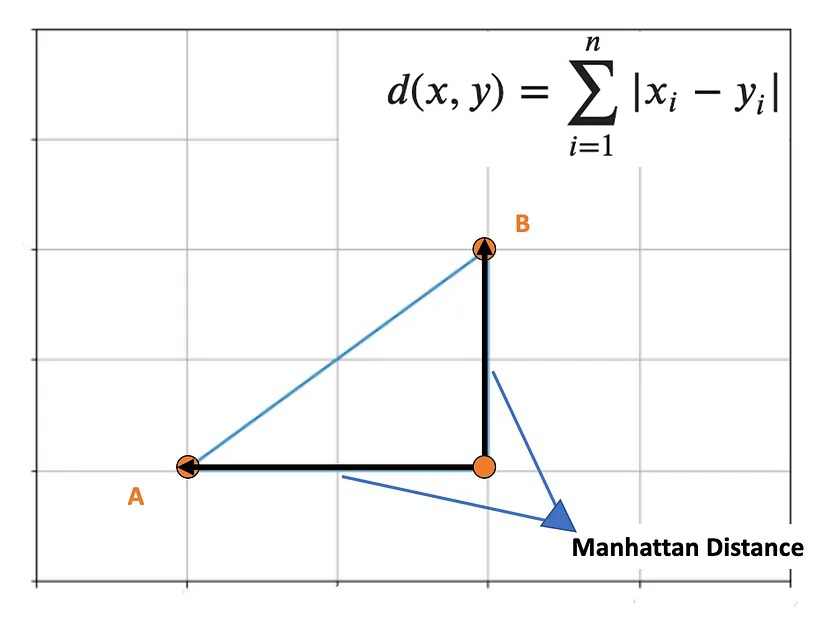

In [28]:
ncc_classifier_manhattan = train_nearest_centroid_classifier(x_train, y_train, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan, x_test, y_test)

print(f"For the Nearest Centroid classifier with Manhattan distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 6.2888s

Testing time: 3.6957s

For the Nearest Centroid classifier with Manhattan distance metric, the accuracy is: 0.1045


Τώρα είναι πιο αργό και ελάχιστα πιο ακριβές (**0.1045**) από πριν.

Γενικά, βλέπω πως έχω πετύχει αρκετά χαμηλή ακριβεία. Για αυτό το λόγο θα χρησιμοποιήσω την μεθόδους του feature extraction για να την βελτιώσω.

# Feature extraction

Η εξαγωγή χαρακτηριστικών (feature extraction) είναι η διαδικασία μετατροπής και μείωσης των πληροφοριών που περιέχονται σε raw data, όπως εικόνες ή κείμενο, σε μια πιο περιεκτική μορφή. Σε δεδομένα εικόνας, η εξαγωγή χαρακτηριστικών συχνά γίνεται με την μέθοδο PCA (Principal Component Analysis) για τη μείωση της διάστασης, καθιστώντας το κατάλληλο για χρήση σε μοντέλα μηχανικής μάθησης. Βοηθά στη βελτίωση της αποδοτικότητας του μοντέλου και μπορεί να αποκαλύψει μοτίβα ή νέα χαρακτηριστικά στα δεδομένα.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

Θέλω το PCA να διατηρήσει τα κύρια στοιχεία που καλύπτουν τουλάχιστον το 90% της διακύμανσης στα δεδομένα, εξού και `n_components=0.90`. Μετά εφαρμόζω το PCA στα δεδομένα και τα μετασχηματίζω.

Ας δούμε την μεταβολή του αριθμού των features.

In [ ]:
print("Number of features before PCA: ", x_train.shape[1])
print("Number of features after PCA: ", x_train_pca.shape[1])

Number of features before PCA:  3072
Number of features after PCA:  87


Από 3072 μειώθηκαν στα 87.

* **1-NN Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2)

starting_time = time.time()

knn_classifier.fit(x_train_pca, y_train)

ending_time = time.time()
print("Training time: {}s\n".format(ending_time-starting_time))

starting_time = time.time()

score = knn_classifier.score(x_test_pca, y_test)

ending_time = time.time()
print("Testing time: {}s\n".format(ending_time-starting_time))

print("For the 1-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.024142742156982422s

Testing time: 5.450880765914917s

For the 1-NN classifier with Euclidean distance metric used accuracy is: 0.1943


Πριν το PCA είχα **0.1755** ακρίβεια, ενώ τώρα **0.1943**. Θα δω τι συμβαίνει και στο 3-NN μοντέλο, αλλά και στα nearest centroid.

* **3-NN Model**

In [ ]:
knn_3 = KNeighborsClassifier(n_neighbors=3, p=2)

starting_time = time.time()

knn_3.fit(x_train_pca, y_train)

ending_time = time.time()
print("Training time: {}s\n".format(ending_time-starting_time))

starting_time = time.time()

score = knn_3.score(x_test_pca, y_test)

ending_time = time.time()
print("Testing time: {}s\n".format(ending_time-starting_time))

print("For the 3-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.047467708587646484s

Testing time: 7.170815467834473s

For the 3-NN classifier with Euclidean distance metric used accuracy is: 0.1645


Εδώ τώρα έχω **0.1645**, ενώ πριν **0.1479**.

* **Ευκλείδια απόσταση**

In [ ]:
ncc = NearestCentroid(metric='euclidean')

start = time.time()

ncc.fit(x_train_pca, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test_pca, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

Training time: 0.06396269798278809s

Testing time: 0.013949871063232422s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.1001


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Εδώ η ακρίβεια έμεινε περίπου ίδια, από **0.1004** πήγε **0.1001**.

* **Απόσταση Μανχάταν**

In [ ]:
ncc = NearestCentroid(metric='manhattan')

start = time.time()

ncc.fit(x_train_pca, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test_pca, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.1422116756439209s

Testing time: 0.14172124862670898s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.1113


Σε αυτό το μοντέλο η ακρίβεια πήγε **0.1113** από το **0.1045**.

# Σύγκριση Μοντέλων

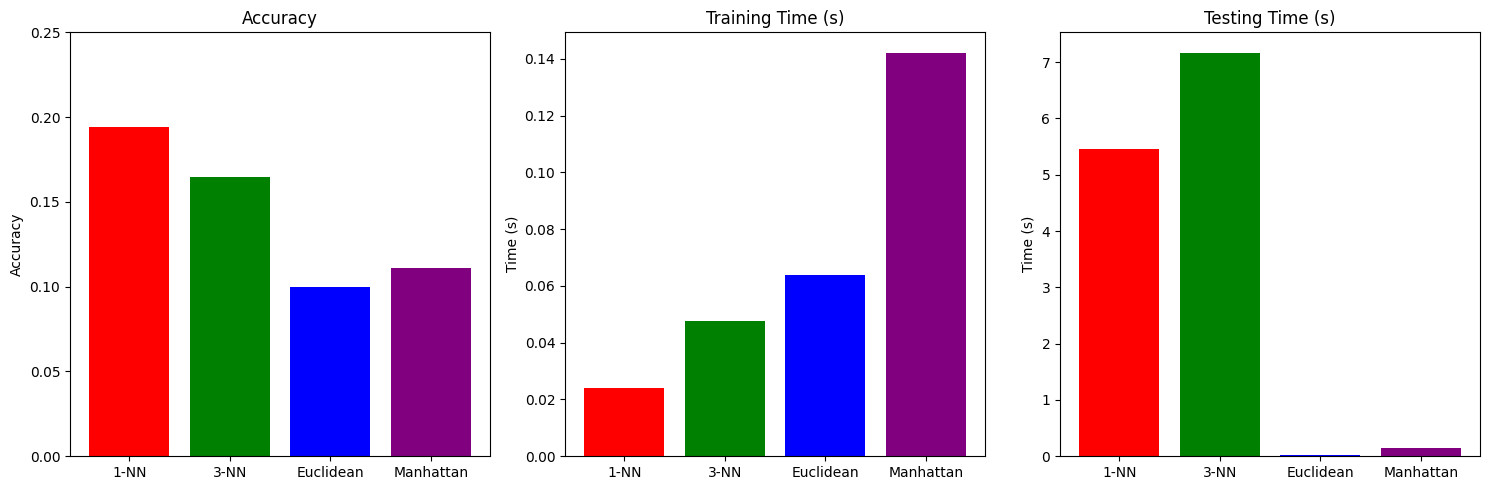

In [ ]:
import matplotlib.pyplot as plt

models = ["1-NN", "3-NN", "Euclidean", "Manhattan"]
accuracies = [0.1943, 0.1645, 0.1001, 0.1113]
training_time = [0.0241, 0.0475, 0.0640, 0.1422]
testing_time = [5.4509, 7.1708, 0.0140, 0.1417]

model_colors = {
    "1-NN": "red",
    "3-NN": "green",
    "Euclidean": "blue",
    "Manhattan": "purple"
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Accuracy
accuracy_colors = [model_colors[model] for model in models]
axs[0].bar(models, accuracies, color=accuracy_colors)
axs[0].set_ylim(0, 0.25)
axs[0].set_title("Accuracy")
axs[0].set_ylabel("Accuracy")

# Subplot 2: Training Time
training_time_colors = [model_colors[model] for model in models]
axs[1].bar(models, training_time, color=training_time_colors)
axs[1].set_title("Training Time (s)")
axs[1].set_ylabel("Time (s)")

# Subplot 3: Testing Time
testing_time_colors = [model_colors[model] for model in models]
axs[2].bar(models, testing_time, color=testing_time_colors)
axs[2].set_title("Testing Time (s)")
axs[2].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()

Βλέπω πως τα μοντέλα NN είναι σαφώς πιο ακριβή, αλλά και πιο αργά στην φάση του testing. Τα Nearest Centroid από την άλλη είναι ταχύτατα, όμως δεν μπορούν να πετύχουν καλές επιδόσεις.

Στη συνέχεια, θα υλοποιηθεί νευρωνικό δίκτυο πολυστρωματικού perceptron (το δίκτυο μπορεί να είναι πλήρως συνδεδεμένο ή
συνελικτικό ή συνδυασμός) που θα εκπαιδεύεται με τον αλγόριθμο back-propagation.

# Βασικό Μοντέλο

Αρχικά, το πρώτο βήμα είναι να κατασκευάσω και να εκπαιδεύσω ένα **βασικό μοντέλο** **MLP (Multilayer Perceptron)** που μπορεί να εφαρμοστεί στο σύνολο δεδομένων μας. Αυτό το μοντέλο θα είναι το θεμέλιο βάσει του οποίου θα αξιολογήσω τα επόμενα μοντέλα που θα αναπτύξω.

Αυτό το αρχικό μοντέλο θα αποτελείται από ένα μόνο κρυφό στρώμα (hidden layer) που θα περιλαμβάνει 256 νευρώνες και ένα στρώμα εξόδου (output layer) με 100 νευρώνες, όπου ο καθένας αντιστοιχεί σε μια ετικέτα του CIFAR100. Η εκπαιδεύση θα διαρκέσει 10 εποχές (epochs), χρησιμοποιώντας batches (παρτίδες) 256 δειγμάτων.

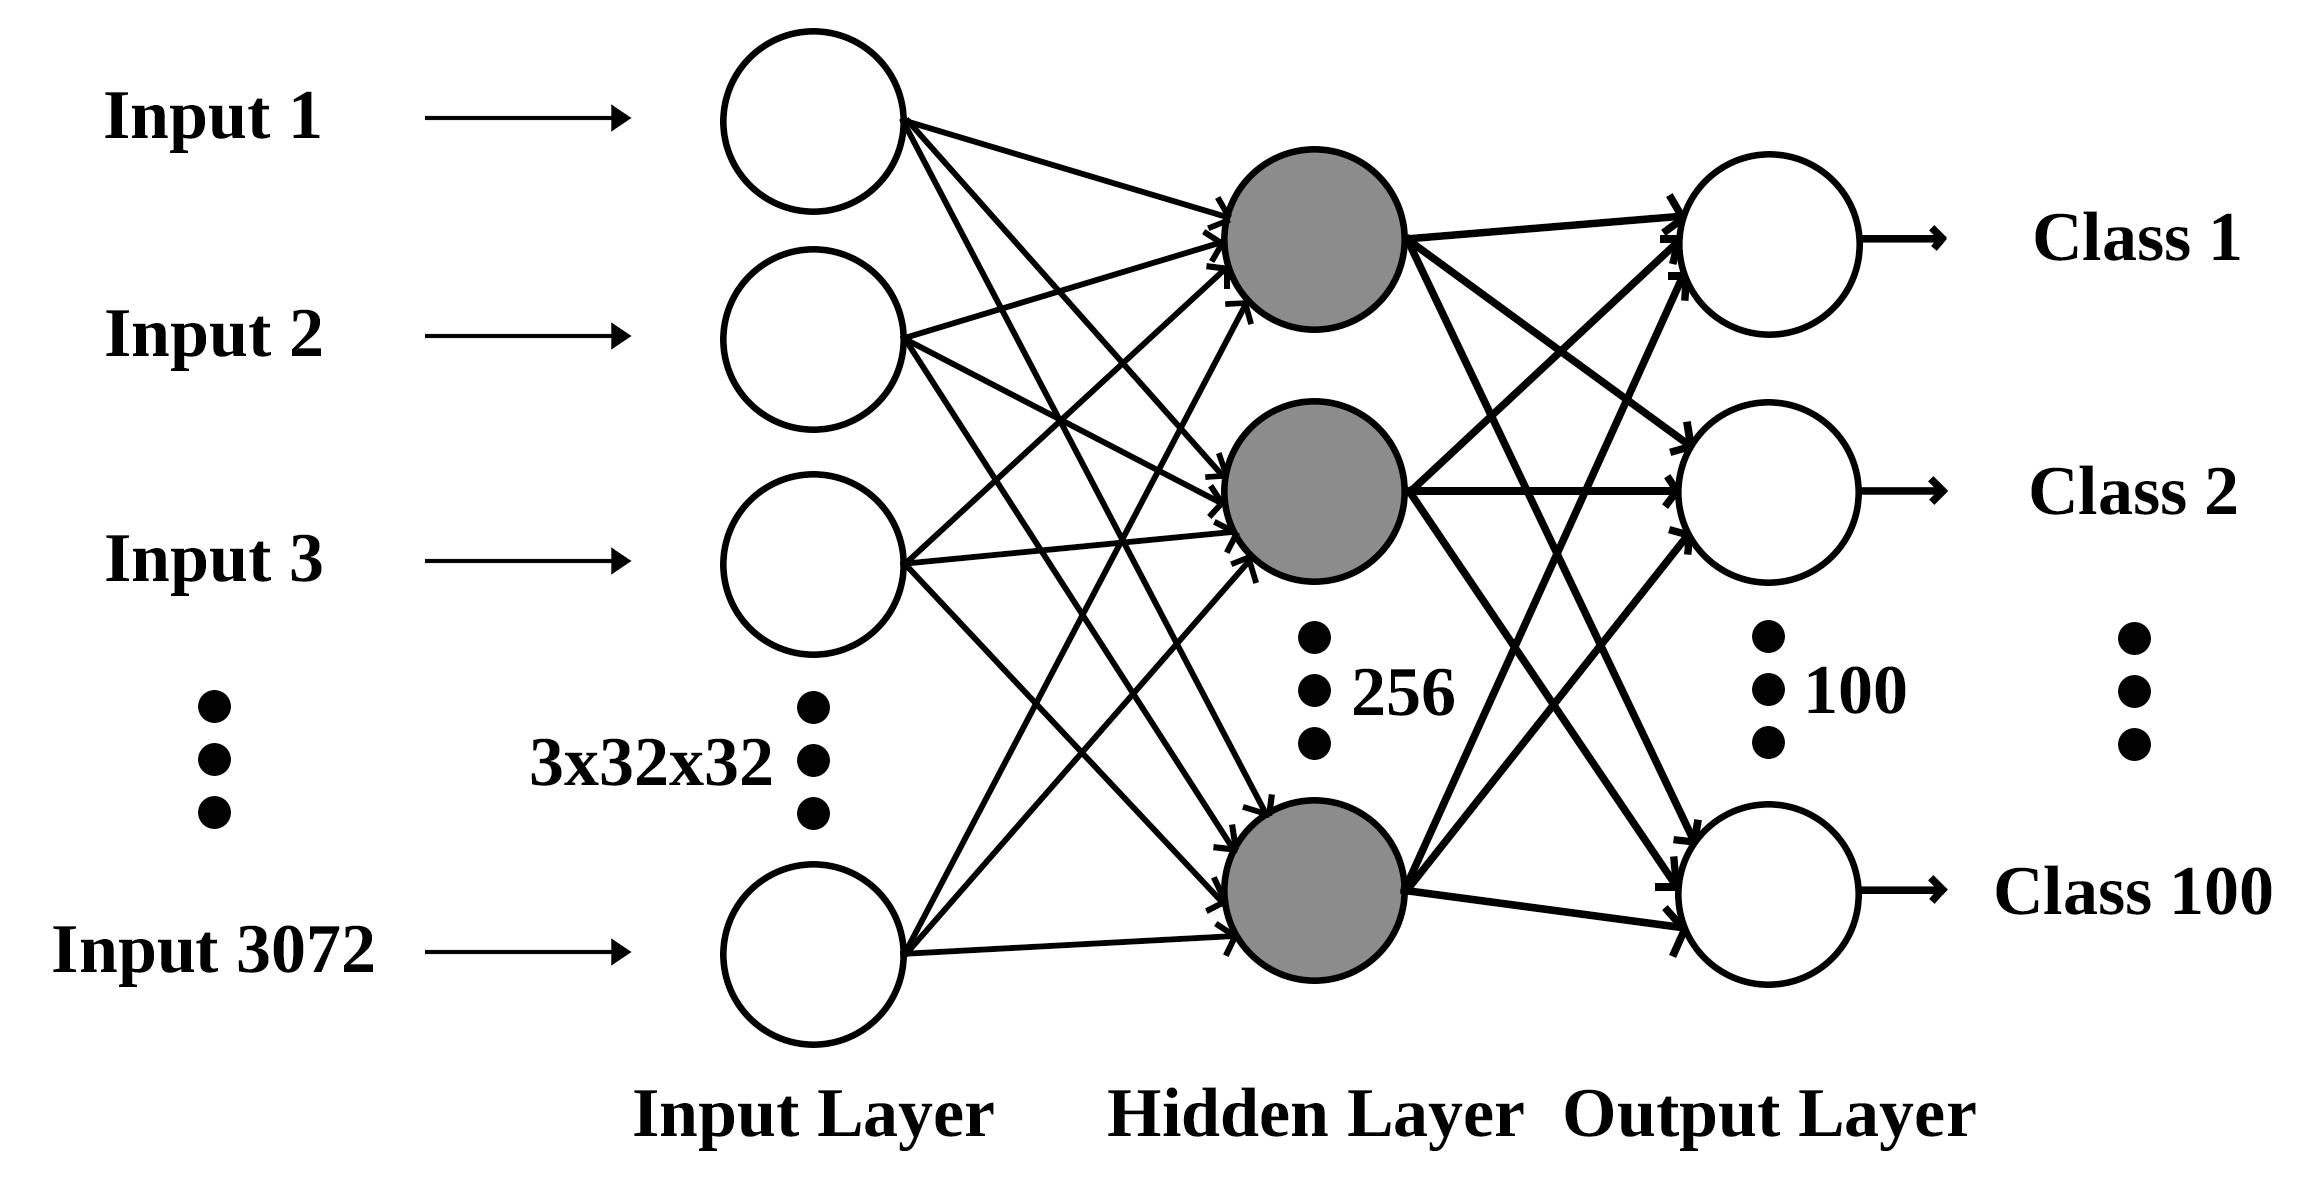

Στα MLPs, τα δεδομένα εισόδου τροφοδοτούνται σε ένα στρώμα εισόδου (input layer) που έχει διάσταση ίση με τη διάσταση του χώρου εισόδου. Στην περίπτωσή μου, αφού τροφοδοτήσω δείγματα εισόδου με 3072 χαρακτηριστικά ανά δείγμα, θα έχω 3072 νευρώνες στο στρώμα εισόδου. Κάθε feature εδώ είναι και ένα pixel από τα *3 (channels) x 32 (height) x 32 (width)*. Αφού υποβληθούν σε επεξεργασία από το στρώμα εισόδου, τα αποτελέσματα περνούν στο επόμενο στρώμα, το οποίο ονομάζεται κρυφό στρώμα. Το τελικό στρώμα είναι η έξοδος. Η δομή των νευρώνων εξαρτάται από το πρόβλημα (δηλαδή έχω ένα νευρώνα στα προβλήματα παλινδρόμησης και δυαδικής ταξινόμησης, ενώ πολλαπλούς νευρώνες σε ένα πρόβλημα ταξινόμησης πολλαπλών κλάσεων).

Κάθε νευρώνας περνάει την είσοδο σε όλους τους νευρώνες του επόμενου (ή downstream) στρώματος. Αυτός είναι ο λόγος για τον οποίο τέτοια στρώματα ονομάζονται επίσης πυκνά συνδεδεμένα (Dense). Στο TensorFlow και στο Keras είναι διαθέσιμα ως `tensorflow.keras.layers.Dense`. Το PyTorch τα χρησιμοποιεί ως `torch.nn.Linear`.


* **Το πρώτο βήμα είναι να προσθέσω όλα τα dependencies.**

Χρειάζομαι το `os` για την είσοδο/έξοδο αρχείων, καθώς θα αποθηκεύσω το σύνολο δεδομένων CIFAR-100 στον τοπικό μου δίσκο αργότερα. Θα εισάγω επίσης το `torch`, για το PyTorch. Από αυτό εισάγω το `nn`, το οποίο μου επιτρέπει να ορίσω ένα νευρωνικό δίκτυο. Εισάγω επίσης το `DataLoader` (για την τροφοδοσία δεδομένων στο MLP κατά τη διάρκεια της εκπαίδευσης), το σύνολο δεδομένων CIFAR100 (προφανώς) και το `transforms`, που επιτρέπει να κάνω μετασχηματισμούς στα δεδομένα πριν τα τροφοδοτήσω στο MLP.

In [ ]:
# Importing all dependencies
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torchvision import transforms

* **Ακολουθεί ο ορισμός της κλάσης MLP.**

Αυτό το Module υλοποιεί το νευρωνικό μου δίκτυο. Έχει δύο ορισμούς συναρτήσεων: `__init__`, δηλαδή τον constructor και `forward` που υλοποιεί το forward pass.

Στον κατασκευαστή, κάνω πρώτα την αρχικοποίηση του `superclass` και μετά ορίζω τα επίπεδα του νευρωνικού μου δικτύου. Στοιβάζω όλα τα επίπεδα (τρία πυκνά συνδεδεμένα στρώματα με `Linear` και `ReLU`), χρησιμοποιώντας το `nn.Sequential`. Προσθέτω επίσης το `nn.Flatten()` στην αρχή. Το `Flatten` μετατρέπει τις αναπαραστάσεις της τρισδιάστατης εικόνας (πλάτος, ύψος και κανάλια) σε μορφή 1D, όπως εξήγησα σε προηγούμενη ενότητα πιο αναλυτικά.

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):

    super().__init__()

    self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 100)  # Output layer with 100 classes
        )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

* **Ορισμός του seed της γεννήτριας.**

Αυτός εκτελείται κατά το χρόνο εκτέλεσης. Ορίζω το seed της γεννήτριας τυχαίων αριθμών. Έτσι διασφαλίζω ότι η ανάλυση μου θα είναι κάθε φορά η ίδια.

In [ ]:
if __name__ == '__main__':

  # Set fixed random number seed
  torch.manual_seed(42)

* **Προετοιμασία του συνόλου δεδομένων CIFAR-100**

Εδώ, καθορίζω το directory όπου θα αποθηκευτεί το σύνολο δεδομένων, το αν πρέπει να γίνει λήψη και το αν πρέπει να μετατραπεί σε μορφή `Tensor`. Μετά αρχικοποιώ το  `DataLoader`, το οποίο παίρνει το σύνολο δεδομένων, το μέγεθος παρτίδας, μια παράμετρο για το αν θα γίνει `shuffle` και τον αριθμό `workers` με τους οποίους θα φορτωθούν δεδομένα. Στο PyTorch, οι `data loaders` χρησιμοποιούνται για την ομοιόμορφη τροφοδοσία δεδομένων στο μοντέλο.

In [ ]:
dataset = CIFAR100(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=1)

100%|██████████| 169001437/169001437 [00:04<00:00, 41882609.86it/s]


Extracting /content/cifar-100-python.tar.gz to /content


Τώρα, αρχικοποιώ και το MLP. Καθορίζω επίσης τη συνάρτηση απώλειας (categorical crossentropy loss) και τον βελτιστοποιητή Adam. Ο βελτιστοποιητής λειτουργεί στις παραμέτρους του MLP και χρησιμοποιεί ρυθμό εκμάθησης 10e-4.

In [ ]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

* **Καθορισμός του training loop**

Το βασικό μέρος του κώδικα είναι ο βρόχος εκπαίδευσης. Σε αυτόν τον βρόχο, εκτελούνται οι εποχές, δηλαδή οι επαναλήψεις εκπαίδευσης. Για κάθε εποχή, επαναλαμβάνω σε όλο το σύνολο δεδομένων εκπαίδευσης το forward και το backward pass και έτσι βελτιστοποιώ το μοντέλο.

Εδώ, χρησιμοποιώ 10 εποχές, όπως ορίζονται από το εύρος `(0, 10)`. Ορίζω την αρχική τιμή απώλειας (`current_loss`) σε 0,0. Ανά εποχή, επαναλαμβάνω το σύνολο δεδομένων εκπαίδευσης και πιο συγκεκριμένα, τις μίνι παρτίδες σε αυτό το σύνολο, όπως καθορίζεται από το `batch_size`. Εδώ, κάνουμε τα εξής:

Χωρίζω τα δεδομένα σε `inputs` και `targets` (τιμές x και y). Μηδενίζω τα gradients στο βελτιστοποιητή (`zero_grad()`), για να διασφαλίσω ότι θα ξεκινήσει από την αρχή για αυτήν τη μίνι παρτίδα. Μετά εκτελώ το forward pass (`outputs = mlp(inputs)`), το οποίο στην πραγματικότητα τροφοδοτεί τις εισόδους στο μοντέλο. Στη συνέχεια, υπολογίζω την τιμή απώλειας με βάση τα αποτελέσματα του μοντέλου και την πραγματικότητα που υπάρχει στα `targets`. Ακολουθεί το backward pass, όπου υπολογίζονται τα gradients και έτσι φτάνω  στην βελτιστοποίηση, όπου το μοντέλο προσαρμόζεται και ιδανικά βελτιώνεται. Τελικά, εκτυπώνω ορισμένα στατιστικά στοιχεία σε κάθε παρτίδα των 28.

In [ ]:
mini_batch_print_interval = 28

# Run the training loop
for epoch in range(0, 10): # 5 epochs at maximum

  # Print epoch
  print(f'Starting epoch {epoch+1}')

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):

    # Get inputs
    inputs, targets = data

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    current_loss += loss.item()
    if i % mini_batch_print_interval == mini_batch_print_interval - 1:
        print(f'Loss after mini-batch {i + 1}: {current_loss / mini_batch_print_interval:.3f}')
        current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch 28: 4.589
Loss after mini-batch 56: 4.545
Loss after mini-batch 84: 4.498
Loss after mini-batch 112: 4.437
Loss after mini-batch 140: 4.372
Loss after mini-batch 168: 4.319
Loss after mini-batch 196: 4.257
Starting epoch 2
Loss after mini-batch 28: 4.210
Loss after mini-batch 56: 4.166
Loss after mini-batch 84: 4.139
Loss after mini-batch 112: 4.100
Loss after mini-batch 140: 4.090
Loss after mini-batch 168: 4.069
Loss after mini-batch 196: 4.031
Starting epoch 3
Loss after mini-batch 28: 4.011
Loss after mini-batch 56: 3.992
Loss after mini-batch 84: 3.996
Loss after mini-batch 112: 3.995
Loss after mini-batch 140: 3.979
Loss after mini-batch 168: 3.950
Loss after mini-batch 196: 3.933
Starting epoch 4
Loss after mini-batch 28: 3.928
Loss after mini-batch 56: 3.898
Loss after mini-batch 84: 3.918
Loss after mini-batch 112: 3.888
Loss after mini-batch 140: 3.869
Loss after mini-batch 168: 3.883
Loss after mini-batch 196: 3.876
Starting epoch 5
Los